In [278]:
import pulp

# Initialize the problem
model = pulp.LpProblem("Minimize_Cost", pulp.LpMinimize)

# O&M costs from IRENA report (DKK/MW)
costs = {'Wind': 41, 'Hydro': 22, 'Biomass': 35, 'SolarPV': 11}

# Capacities from IRENA report (MW)
capacities = {'Wind': 27940896, 'Hydro': 33040, 'Biomass': 9425760, 'SolarPV': 4060161}

# CO2 emissions (gCO2eq/MW)
emissions = {'Wind': 11500, 'Hydro': 24000, 'Biomass': 230000, 'SolarPV': 41000}

# Total CO2 emissions limit (gCO2)
max_emissions = 6486695983900 

# Electricity demand for each timestep (MWh)
demand = [10849000, 7239000, 6819000, 9192000]

# Define the Total Production limit (TP)
TP = sum(demand)  

# Decision variables for each timestep, assuming four timesteps
W = {t: pulp.LpVariable(f"W_{t}", lowBound=0) for t in range(1, 5)}
H = {t: pulp.LpVariable(f"H_{t}", lowBound=0) for t in range(1, 5)}
B = {t: pulp.LpVariable(f"B_{t}", lowBound=0) for t in range(1, 5)}
PV = {t: pulp.LpVariable(f"PV_{t}", lowBound=0) for t in range(1, 5)}

# Objective function: Minimize O&M costs
model += pulp.lpSum([costs['Wind'] * W[t] + costs['Hydro'] * H[t] + costs['Biomass'] * B[t] + costs['SolarPV'] * PV[t] for t in range(1, 5)])

# Non-negativity constraints (Constraints 1 - 4)
for t in range(1, 5):
    model += W[t] >= 0, f"Non-negativity Wind t{t}"
    model += H[t] >= 0, f"Non-negativity Hydro t{t}"
    model += B[t] >= 0, f"Non-negativity Biomass t{t}"
    model += PV[t] >= 0, f"Non-negativity SolarPV t{t}"

# A small tolerance to simulate strict inequality
tolerance = 1e-6

# Adding Seasonal Constraints for Solar PV
model += PV[1] <= PV[2] - tolerance, "Solar PV Constraint T1 < T2"
model += PV[2] <= PV[3] - tolerance, "Solar PV Constraint T2 < T3"
model += PV[4] <= PV[2] - tolerance, "Solar PV Constraint T4 < T2"

# Adding Seasonal Constraints for Wind
model += W[2] <= W[1] - tolerance, "Wind Constraint T2 < T1"
model += W[3] <= W[2] - tolerance, "Wind Constraint T3 < T2"
model += W[2] <= W[4] - tolerance, "Wind Constraint T2 < T4"

# Electricity demand for each timestep (MWh)
demand = [10849000, 7239000, 6819000, 9192000]

min_wind_production = 0.07 * TP  
# Adding minimum biomass production constraints for each timestep
for t in range(1, 5):
    model += W[t] >= min_wind_production, f"Minimum Wind Production t{t}"

min_biomass_production = 0.03 * TP  
# Adding minimum biomass production constraints for each timestep
for t in range(1, 5):
    model += B[t] >= min_biomass_production, f"Minimum Biomass Production t{t}"
    
min_solar_production = 0.015 * TP  
# Adding minimum solar production constraints for each timestep
for t in range(1, 5):
    model += PV[t] >= min_solar_production, f"Minimum Solar Production t{t}"
    
    
min_hydro_production = 0.0001 * TP  
# Adding minimum hydro production constraints for each timestep
for t in range(1, 5):
    model += H[t] >= min_hydro_production, f"Minimum Hydro Production t{t}"    

# Capacity constraints summed across all timesteps (annual capacity, Constraints 5 - 8)

model += pulp.lpSum([W[t] for t in range(1, 5)]) <= capacities['Wind'], "Total Wind Capacity Constraint"
model += pulp.lpSum([H[t] for t in range(1, 5)]) <= capacities['Hydro']  , "Total Hydro Capacity Constraint"
model += pulp.lpSum([B[t] for t in range(1, 5)]) <= capacities['Biomass']  , "Total Biomass Capacity Constraint"
model += pulp.lpSum([PV[t] for t in range(1, 5)]) <= capacities['SolarPV'] , "Total Solar PV Capacity Constraint"

# Emissions constraint (summed across all timesteps, Constraint 9)
model += pulp.lpSum([W[t] * emissions['Wind'] + H[t] * emissions['Hydro'] + B[t] * emissions['Biomass'] + PV[t] * emissions['SolarPV'] for t in range(1, 5)]) <= max_emissions, "Total Emissions Constraint"

# Demand constraints for each timestep (Constraint 10)
for t in range(1, 5):
    model += W[t] + H[t] + B[t] + PV[t] == demand[t-1], f"Demand Constraint t{t}"

# Total production constraint (Constraint 11)
model += pulp.lpSum([W[t] + H[t] + B[t] + PV[t] for t in range(1, 5)]) <= TP, "Total Production Constraint"

# Solve the model
model.solve()

# Output the results
for t in range(1, 5):
    print(f"Time Step {t}:")
    print(f"Wind: {W[t].varValue} MWh")
    print(f"Hydro: {H[t].varValue} MWh")
    print(f"Biomass: {B[t].varValue} MWh")
    print(f"Solar PV: {PV[t].varValue} MWh")
print(f"Total Cost: {pulp.value(model.objective)} DKK")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kotro/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/dl/k02sh41x07vdsk4cqwn08c580000gn/T/1bd6741dc5944a39a0df230a2d314936-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/dl/k02sh41x07vdsk4cqwn08c580000gn/T/1bd6741dc5944a39a0df230a2d314936-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 53 COLUMNS
At line 178 RHS
At line 227 BOUNDS
At line 228 ENDATA
Problem MODEL has 48 rows, 16 columns and 108 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 11 (-37) rows, 13 (-3) columns and 44 (-64) elements
0  Obj 1.0891618e+09 Primal inf 4194189.2 (2) Dual inf 109.99999 (6)
11  Obj 1.2190718e+09
Optimal - objective value 1.2190718e+09
After Postsolve, objective 1.2190718e+09, infeasibilities - dual 0 (0), primal 9e-07 (1)
Presolved model was optimal, fu

In [279]:
import matplotlib.pyplot as plt

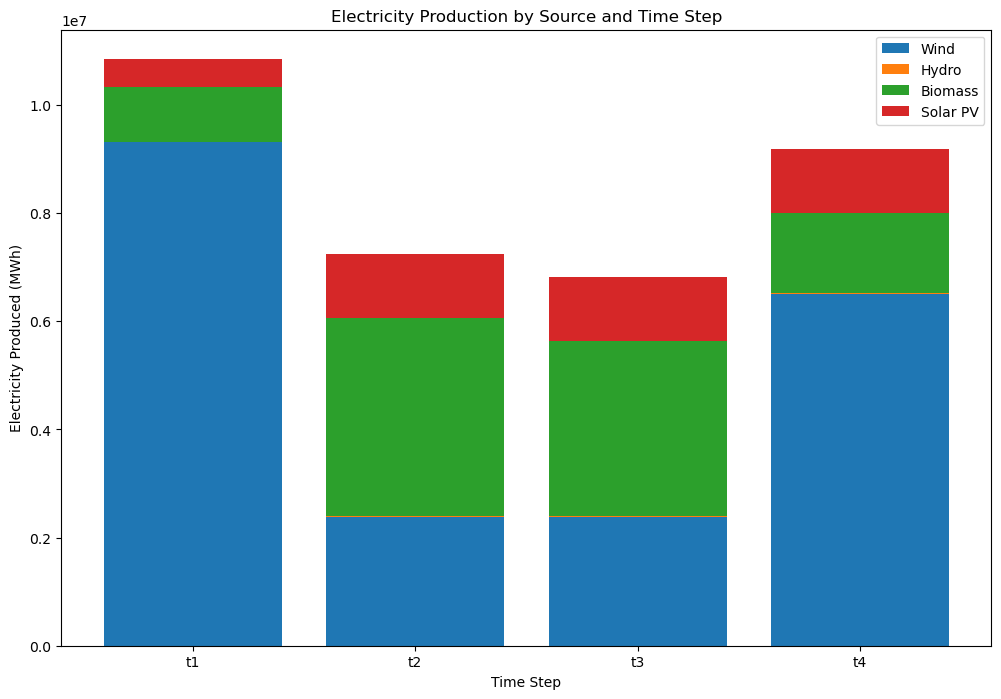

In [280]:
# Assuming the model has been solved and W, H, B, and PV contain the solution values
time_steps = ['t1', 't2', 't3', 't4']
wind_production = [W[t].varValue for t in range(1, 5)]
hydro_production = [H[t].varValue for t in range(1, 5)]
biomass_production = [B[t].varValue for t in range(1, 5)]
solar_production = [PV[t].varValue for t in range(1, 5)]

# Graph 1: Electricity Production by Source and Time Step
plt.figure(figsize=(12, 8))
plt.bar(time_steps, wind_production, label='Wind', bottom=[0, 0, 0, 0])
plt.bar(time_steps, hydro_production, label='Hydro', bottom=wind_production)
plt.bar(time_steps, biomass_production, label='Biomass', bottom=[w + h for w, h in zip(wind_production, hydro_production)])
plt.bar(time_steps, solar_production, label='Solar PV', bottom=[w + h + b for w, h, b in zip(wind_production, hydro_production, biomass_production)])
plt.xlabel('Time Step')
plt.ylabel('Electricity Produced (MWh)')
plt.title('Electricity Production by Source and Time Step')
plt.legend()
plt.show()

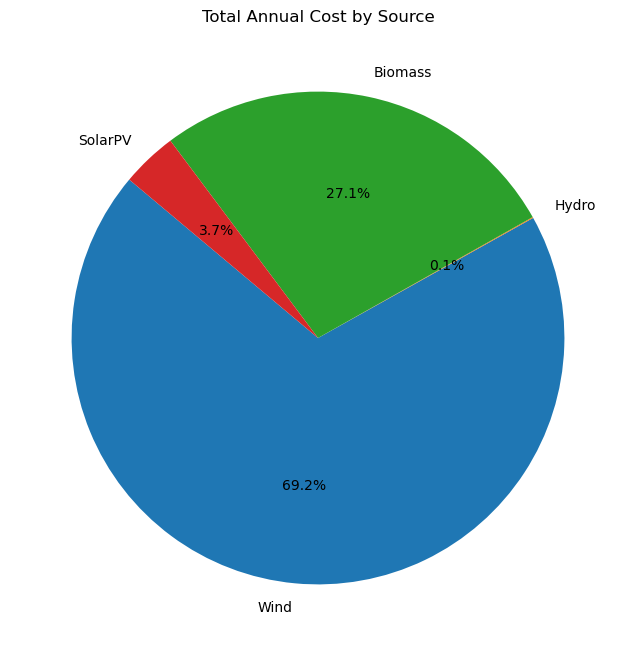

In [281]:
# Graph 2: Total Annual Cost by Source
total_costs = {
    'Wind': sum(wind_production) * costs['Wind'],
    'Hydro': sum(hydro_production) * costs['Hydro'],
    'Biomass': sum(biomass_production) * costs['Biomass'],
    'SolarPV': sum(solar_production) * costs['SolarPV']
}
plt.figure(figsize=(8, 8))
plt.pie(total_costs.values(), labels=total_costs.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Total Annual Cost by Source')
plt.show()


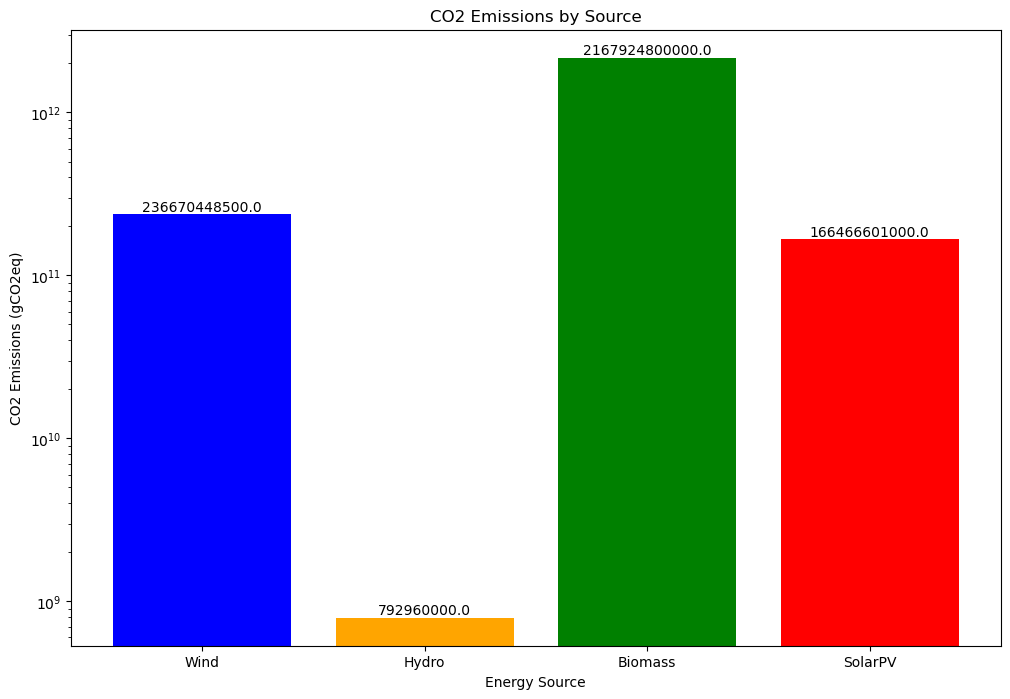

In [282]:
# Graph 3: CO2 Emissions by Source
total_emissions = {
    'Wind': sum([W[t].varValue for t in range(1, 5)]) * emissions['Wind'],
    'Hydro': sum([H[t].varValue for t in range(1, 5)]) * emissions['Hydro'],
    'Biomass': sum([B[t].varValue for t in range(1, 5)]) * emissions['Biomass'],
    'SolarPV': sum([PV[t].varValue for t in range(1, 5)]) * emissions['SolarPV']
}
colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(12, 8))
#bars = plt.bar(total_emissions.keys(), total_emissions.values())
bars = plt.bar(total_emissions.keys(), total_emissions.values(), color=colors)
plt.xlabel('Energy Source')
plt.ylabel('CO2 Emissions (gCO2eq)')
plt.title('CO2 Emissions by Source')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Adding the actual emission numbers on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


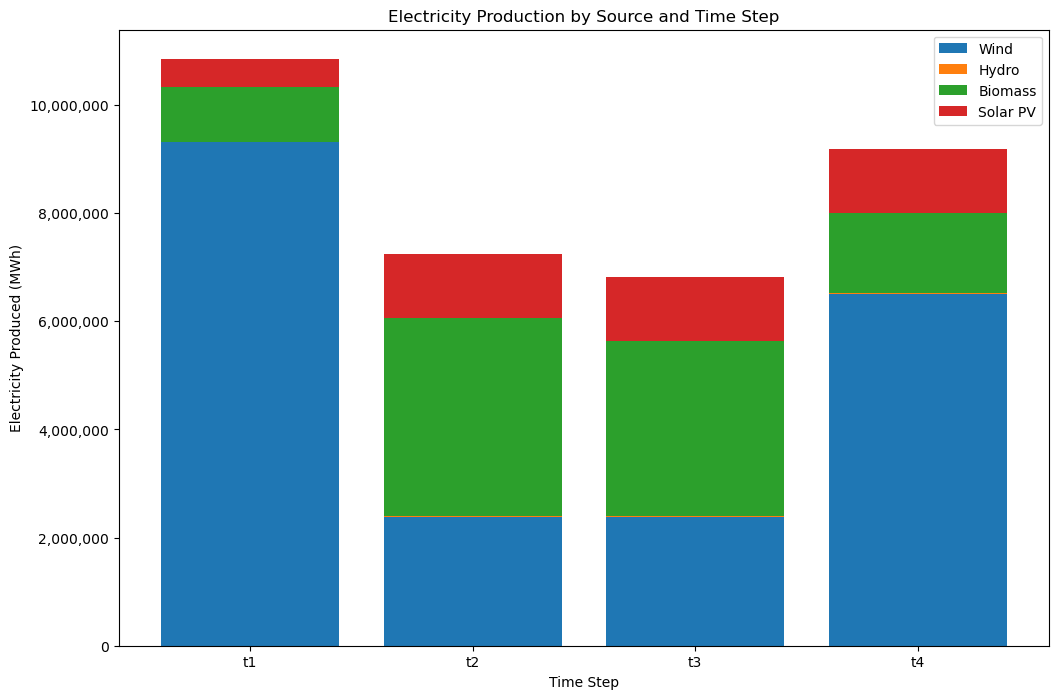

In [283]:
import matplotlib.ticker as mticker

# Given production data for each source and timestep (replace with your actual data)
wind_production = [9311135.1, 2386930.0, 2386930.0, 6495043.9]
hydro_production = [3409.9, 3409.9, 3409.9, 22810.3]
biomass_production = [1022970.0, 3665768.1, 3245768.1, 1491253.8]
solar_production = [511485.0, 1182892.0, 1182892.0, 1182892.0]
time_steps = ['t1', 't2', 't3', 't4']

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))
plt.bar(time_steps, wind_production, label='Wind', bottom=[0, 0, 0, 0])
plt.bar(time_steps, hydro_production, label='Hydro', bottom=wind_production)
plt.bar(time_steps, biomass_production, label='Biomass', bottom=[w + h for w, h in zip(wind_production, hydro_production)])
plt.bar(time_steps, solar_production, label='Solar PV', bottom=[w + h + b for w, h, b in zip(wind_production, hydro_production, biomass_production)])

# Set the y-axis labels to display as plain numbers
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.xlabel('Time Step')
plt.ylabel('Electricity Produced (MWh)')
plt.title('Electricity Production by Source and Time Step')
plt.legend()

# Display the plot
plt.show()